# Receiver Operating Characteristic (ROC) with cross validation


### ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

### The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

### The ROC response of different datasets, created from K-fold cross-validation is an unbiased assessement of a classifier performanc, since, it is possible to calculate the mean area under curve, and see the variance of the curve when the training set is split into different subsets. This roughly shows how the classifier output is affected by changes in the training data, and how different the splits generated by K-fold cross-validation are from one another.

source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html


## 1) Read original Datasets

In [1]:
import sys
import os
sys.path.insert(0,'Z:/Cristina/Section3/NME_DEC')

import mxnet as mx
import numpy as np
import pandas as pd

from utilities import *
import data
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging

from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import sklearn.neighbors 
import matplotlib.patches as mpatches
from sklearn.utils.linear_assignment_ import linear_assignment

try:
   import cPickle as pickle
except:
   import pickle
import gzip

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#####################################################
## 1) read in the datasets both all NME (to do pretraining)
NME_nxgraphs = r'Z:\Cristina\Section3\breast_MR_NME_biological\NMEs_SER_nxgmetrics'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)
   
allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)

# to load discrall_dict dict for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGnormfeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    discrall_dict_allNMEs = pickle.load(fin)         

allNME_featurenames = pd.read_csv(os.path.join(NME_nxgraphs,'named_nxGnormfeatures_allNMEs_descStats.csv'), index_col=0)

#########
# shape input (798L, 427L)    
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} all nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, allNMEs_dynamic.as_matrix(), allNMEs_morphology.as_matrix(), allNMEs_texture.as_matrix(), allNMEs_stage1.as_matrix()), axis=1)       
X_allNME_featurenames = np.concatenate((np.vstack(allNME_featurenames.columns),np.vstack(allNMEs_dynamic.columns),np.vstack(allNMEs_morphology.columns),np.vstack(allNMEs_texture.columns),np.vstack(allNMEs_stage1.columns)), axis=0).flatten()  

YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

# define variables for DEC 
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

## use y_dec to  minimizing KL divergence for clustering with known classes
ysup = ["{}_{}_{}".format(a, b, c) if b!='nan' else "{}_{}".format(a, c) for a, b, c in zip(YnxG_allNME[1], YnxG_allNME[2], YnxG_allNME[3])]
ysup = ['K'+rl[1::] if rl[0]=='U' else rl for rl in ysup]
classes = [str(c) for c in np.unique(ysup)]
numclasses = [i for i in range(len(classes))]
y_dec = []
for k in range(len(ysup)):
    for j in range(len(classes)):
        if(str(ysup[k])==classes[j]): 
            y_dec.append(numclasses[j])
y_dec = np.asarray(y_dec)


Loading 792 all nxGdiscfeatures of size = 326
Loading 792 all NME of size = 523
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


#############################################################################
# Compare formally supervised and semi-supervised learning

## 1) Supervised learning in HD space:

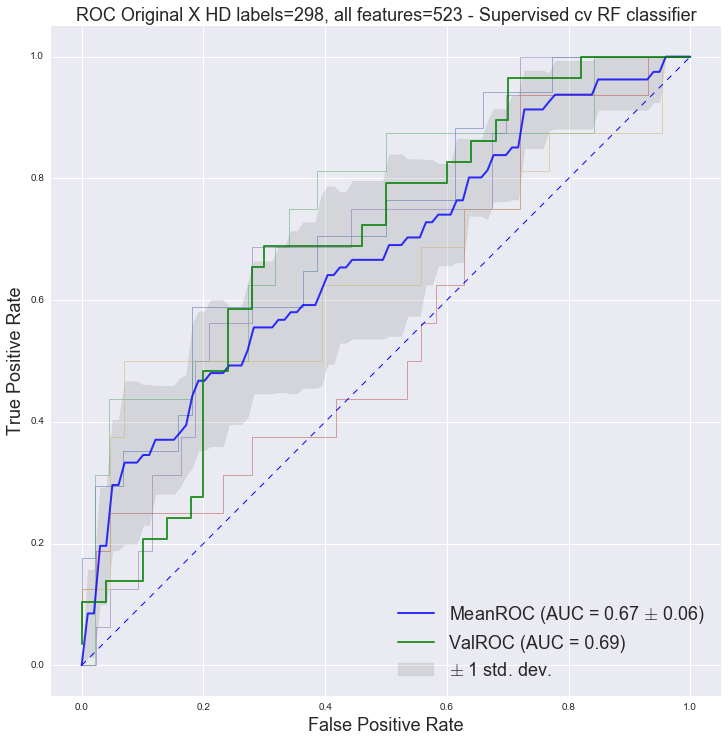

In [2]:
# unbiased validation with held-out set
combX_allNME[np.isnan(combX_allNME)] = 0.00001
sep = int(combX_allNME.shape[0]*0.10)
X_val = combX_allNME[:sep]
y_val = roi_labels[:sep]

X_train = combX_allNME[sep:]
y_train = roi_labels[sep:]

# Classification and ROC analysis
datalabels = np.asarray(y_train)
dataspace = X_train
X = dataspace[datalabels!='K',:]
y = np.asarray(datalabels[datalabels!='K']=='M').astype(int)

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
RFmodel = RandomForestClassifier(n_jobs=2, n_estimators=500, max_depth=3, random_state=0, verbose=0)

# Evaluate a score by cross-validation
figROCs = plt.figure(figsize=(12,12))                  
tprs = []; aucs = []
mean_fpr = np.linspace(0, 1, 100)
cvi = 0
for train, test in cv.split(X, y):
    probas = RFmodel.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas[:, 1])
    # to create an ROC with 100 pts
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # plot
    axaroc = figROCs.add_subplot(1,1,1)
    axaroc.plot(fpr, tpr, lw=1, alpha=0.5) # with label add: label='cv %d, AUC %0.2f' % (cvi, roc_auc)
    cvi += 1

axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b',alpha=1)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
axaroc.plot(mean_fpr, mean_tpr, color='b',
         label=r'MeanROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)     
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.') 

################
# plot AUC on validation set
################
y_val_bin = (np.asarray(y_val)=='M').astype(int)
probas_val = RFmodel.fit(X, y).predict_proba(X_val)

# Compute ROC curve and area the curve
fpr_val, tpr_val, thresholds_val = roc_curve(y_val_bin, probas_val[:, 1])
auc_val = auc(fpr_val, tpr_val)
axaroc.plot(fpr_val, tpr_val, color='g',
            label=r'ValROC (AUC = %0.2f)' % (auc_val),
             lw=2, alpha=.8)     


axaroc.set_xlim([-0.05, 1.05])
axaroc.set_ylim([-0.05, 1.05])
axaroc.set_xlabel('False Positive Rate',fontsize=18)
axaroc.set_ylabel('True Positive Rate',fontsize=18)
axaroc.set_title('ROC Original X HD labels={}, all features={} - Supervised cv RF classifier'.format(X.shape[0],X.shape[1]), fontsize=18)
axaroc.legend(loc="lower right",fontsize=18)

# Explore variable importances

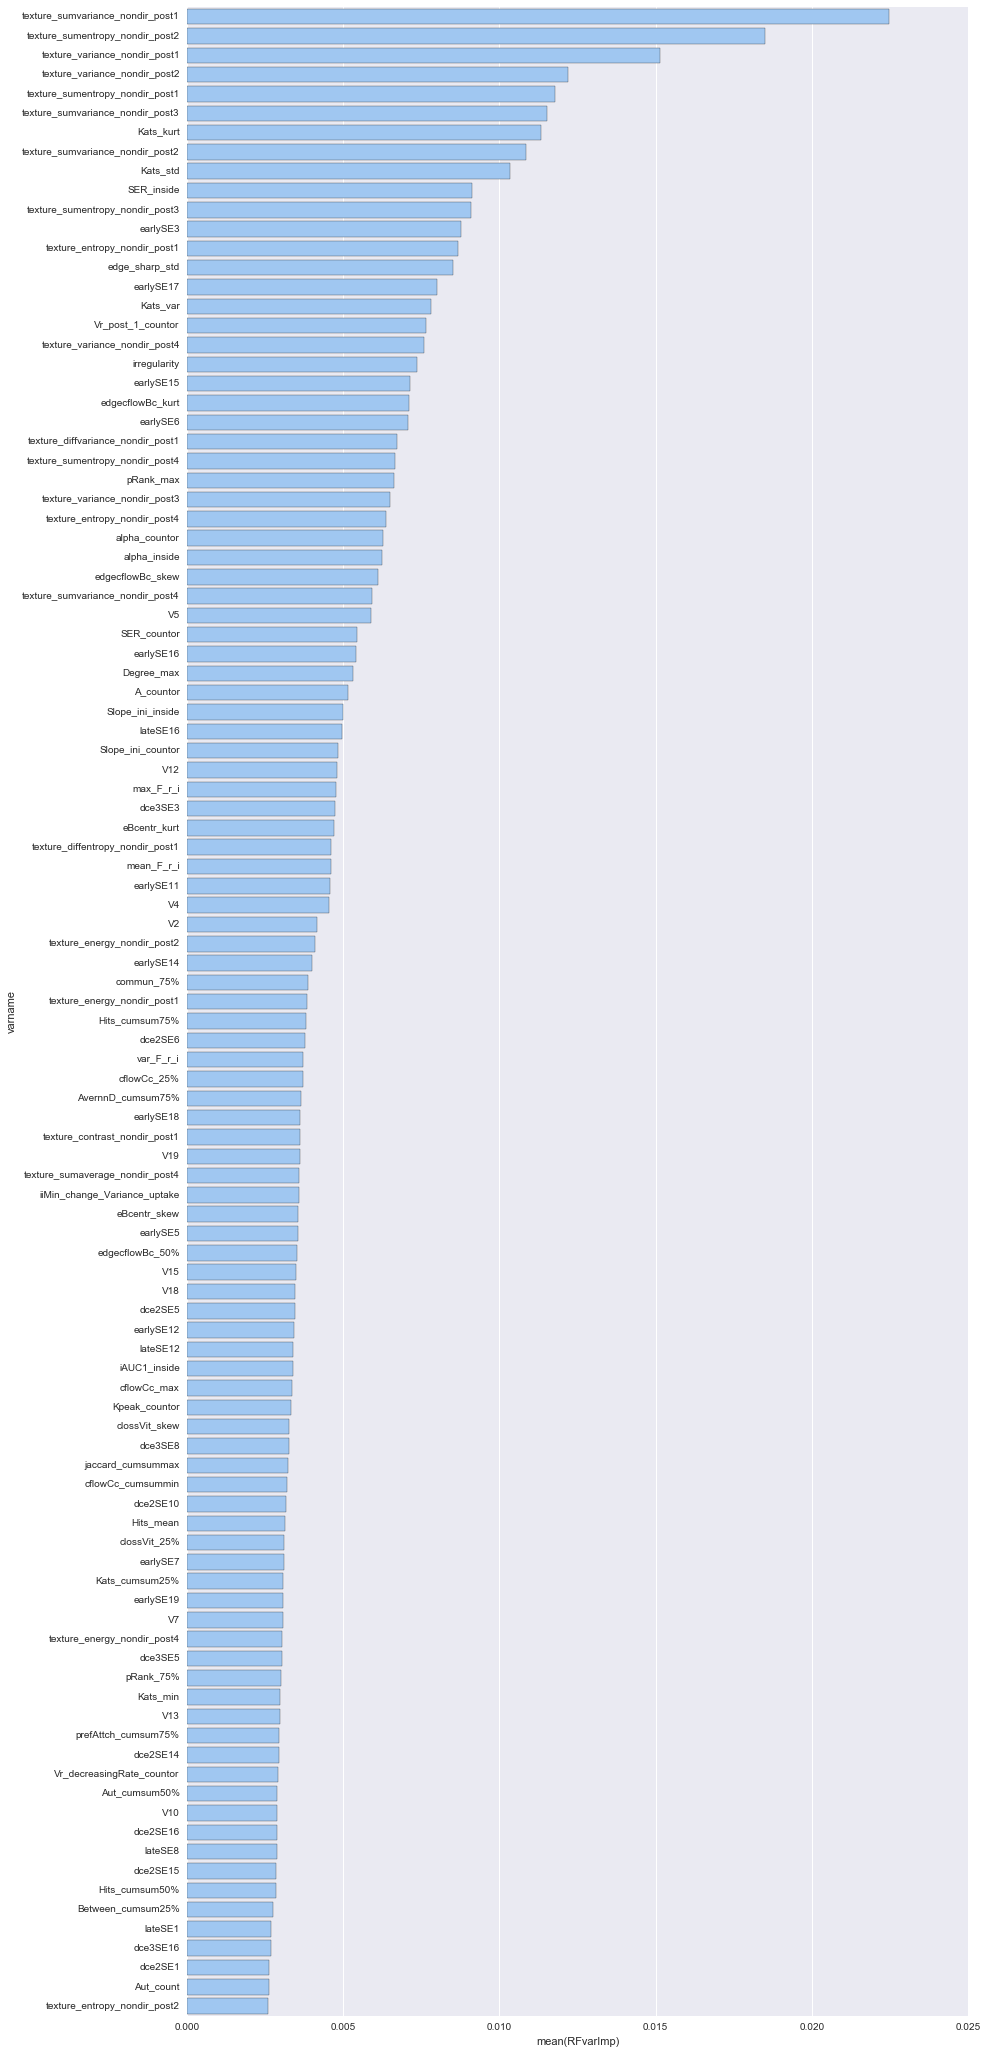

In [3]:
ind_featImp = np.argsort(RFmodel.feature_importances_)[::-1]
X_allNME_featurenames[ind_featImp]

# create pandas dF with variable importabces
RFfeatImportances = pd.DataFrame({'varname':X_allNME_featurenames[ind_featImp], 'RFvarImp':np.sort(RFmodel.feature_importances_)[::-1]})

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 36))
# Plot the total crashes
sns.set_color_codes("pastel")
# of all 523 variables seclec those wiht positive varImportances
varDiscrim = RFfeatImportances[RFfeatImportances['RFvarImp']>0.0]

# top 20% = 523*0.20
varDiscrim = RFfeatImportances.iloc[0:int(523*0.20)]
sns.barplot(x="RFvarImp", y="varname", data=varDiscrim, label="varname", color="b")


#############################################################################
## 2) Unsupervised learning in optimal LD space:

### NOTES:  Z-space takes normalized variables  (zero mean and unit variance)

In [ ]:
### Read input variables
# shape input (792, 523)     
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(allNMEs_dynamic.shape[0], allNMEs_dynamic.shape[1]))
normdynamic = (allNMEs_dynamic - allNMEs_dynamic.mean(axis=0)) / allNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)
print(np.min(normdynamic, 0))
print(np.max(normdynamic, 0))

print('Normalizing morphology {} leasions with features of size = {}'.format(allNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (allNMEs_morphology - allNMEs_morphology.mean(axis=0)) / allNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)
print(np.min(normorpho, 0))
print(np.max(normorpho, 0))

print('Normalizing texture {} leasions with features of size = {}'.format(allNMEs_texture.shape[0], allNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / allNMEs_texture.std(axis=0)
normtext.mean(axis=0)
print(np.min(normtext, 0))
print(np.max(normtext, 0))

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (allNMEs_stage1 - allNMEs_stage1.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)
print(np.min(normstage1, 0))
print(np.max(normstage1, 0))    

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0]) )


##  Experiment:  Fitting a RF classifier to Zspace

Loading autoencoder of znum = 261, mu = 3 , post training DEC results


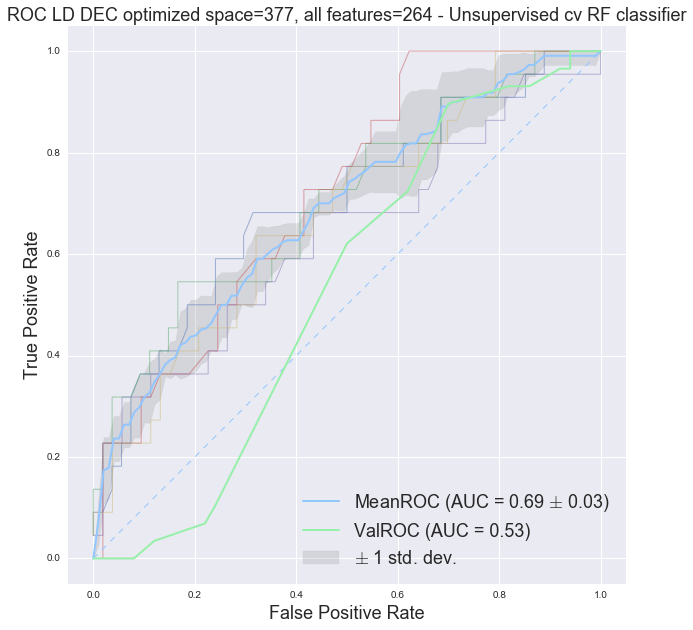

Loading autoencoder of znum = 261, mu = 4 , post training DEC results


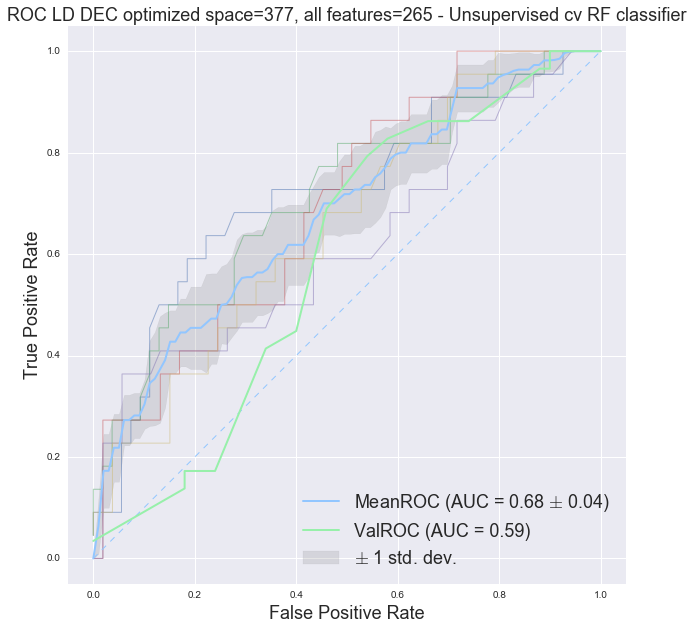

Loading autoencoder of znum = 261, mu = 5 , post training DEC results


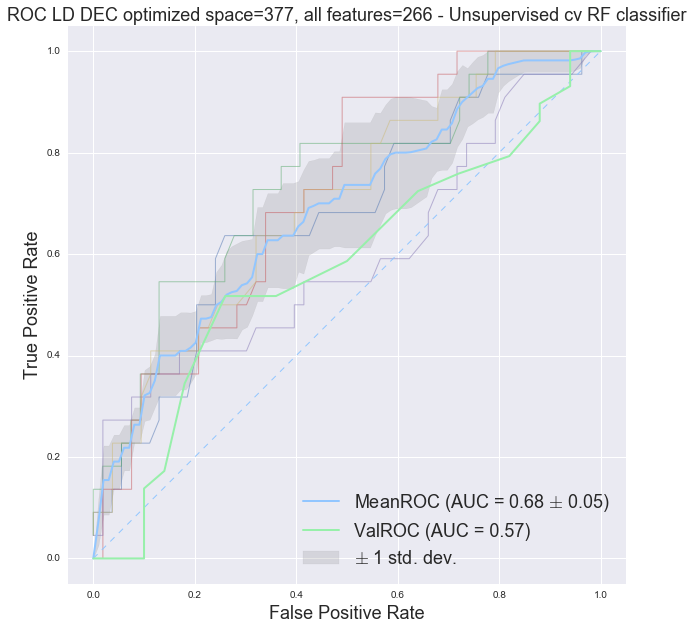

Loading autoencoder of znum = 261, mu = 6 , post training DEC results


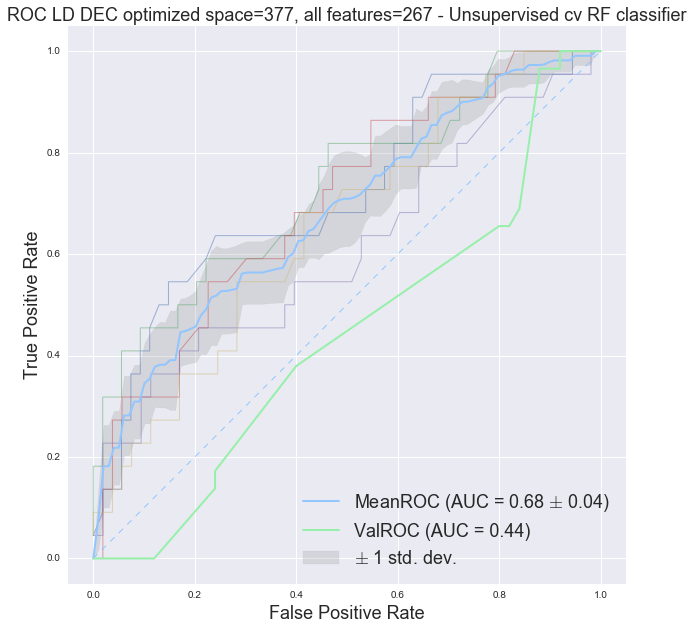

Loading autoencoder of znum = 261, mu = 7 , post training DEC results


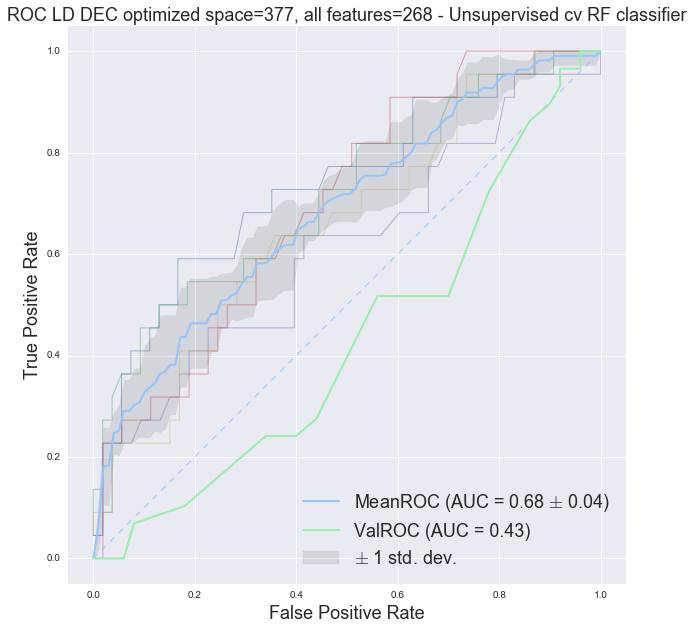

Loading autoencoder of znum = 261, mu = 8 , post training DEC results


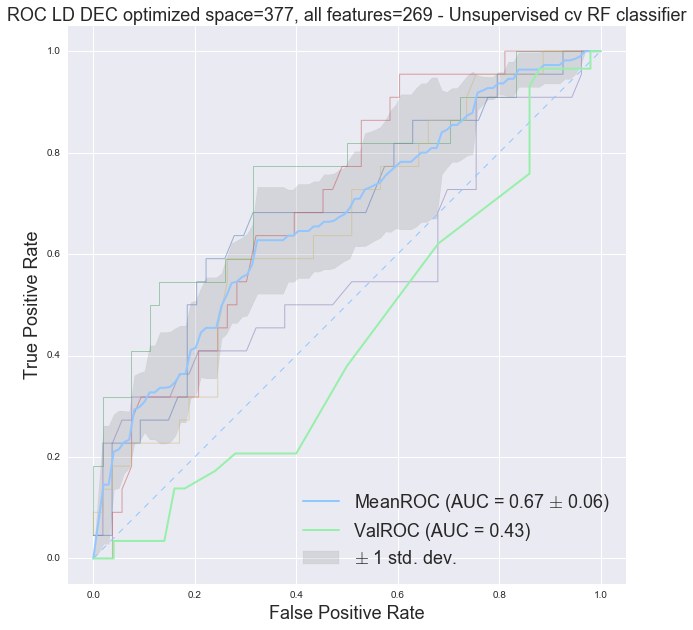

Loading autoencoder of znum = 261, mu = 9 , post training DEC results


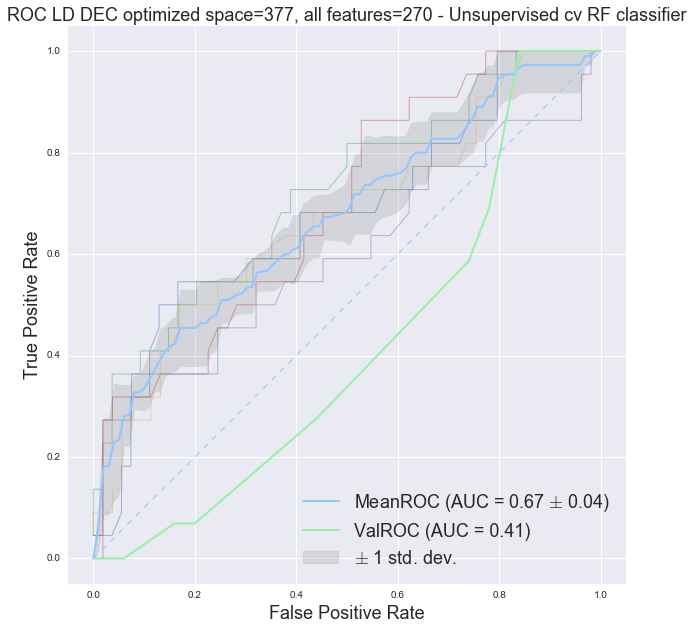

Loading autoencoder of znum = 261, mu = 10 , post training DEC results


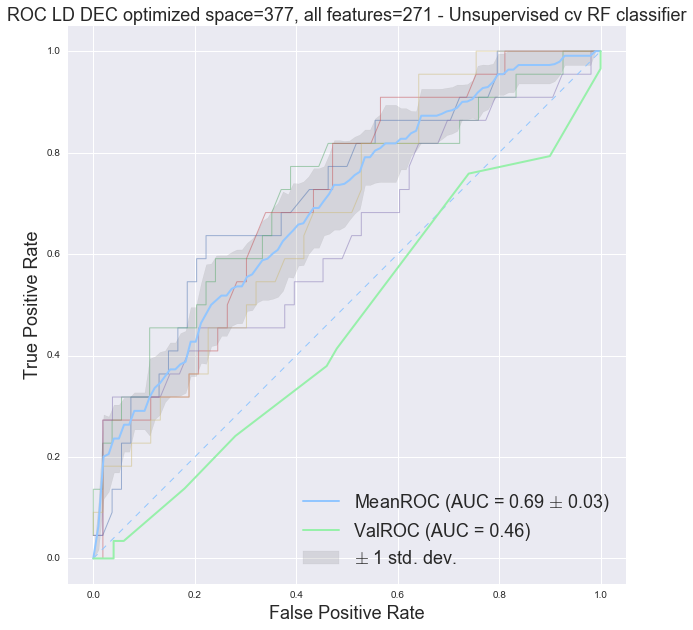

Loading autoencoder of znum = 104, mu = 3 , post training DEC results


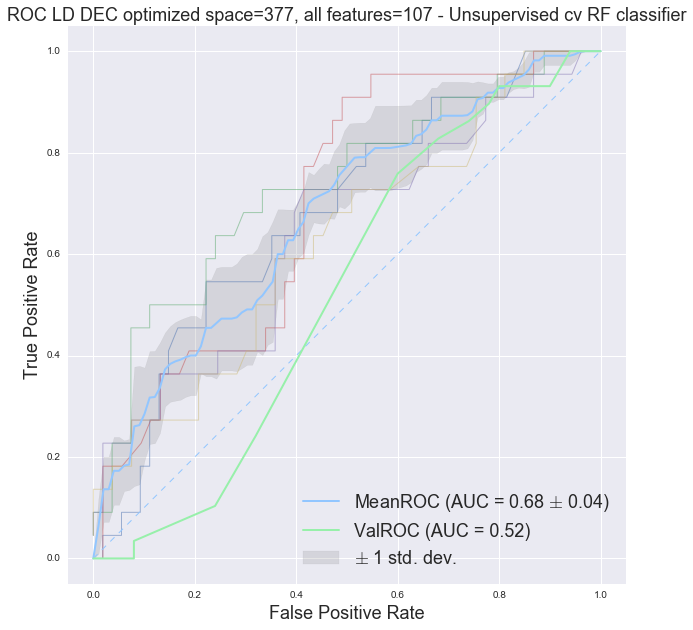

Loading autoencoder of znum = 104, mu = 4 , post training DEC results


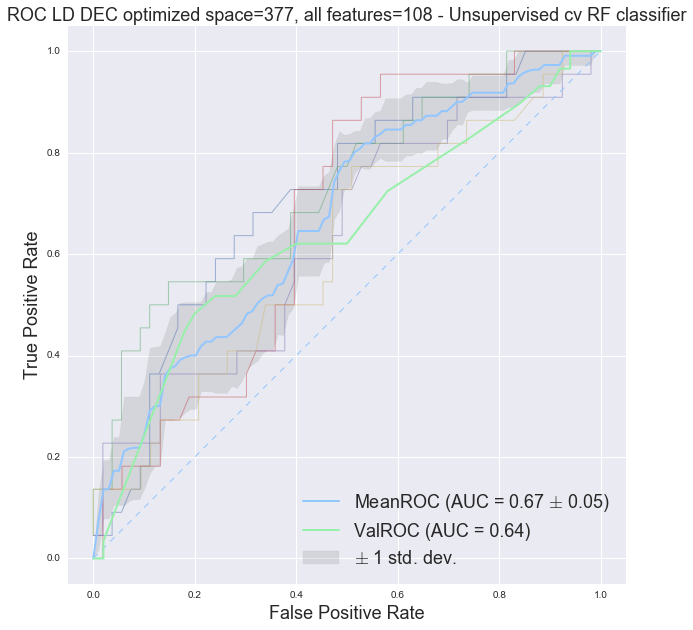

Loading autoencoder of znum = 104, mu = 5 , post training DEC results


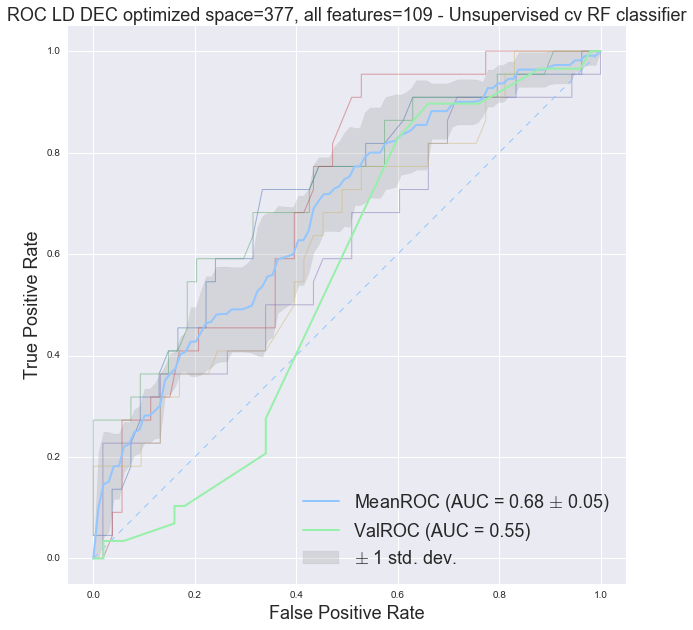

Loading autoencoder of znum = 104, mu = 6 , post training DEC results


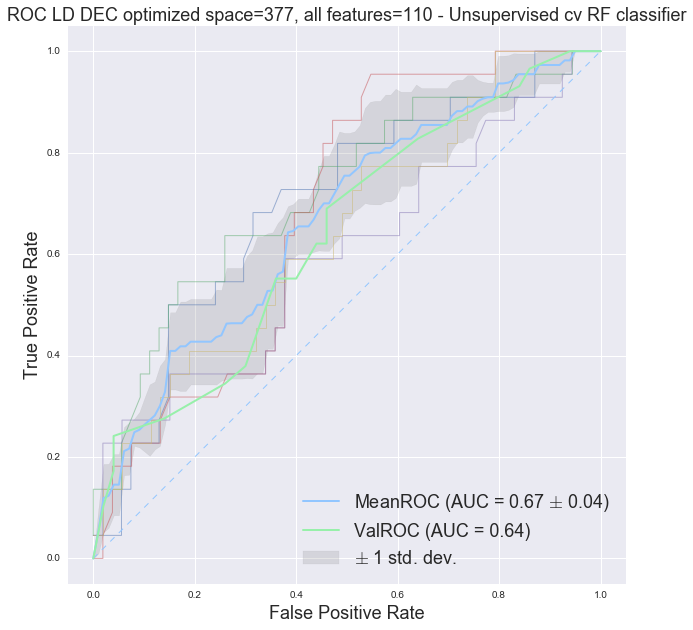

Loading autoencoder of znum = 104, mu = 7 , post training DEC results


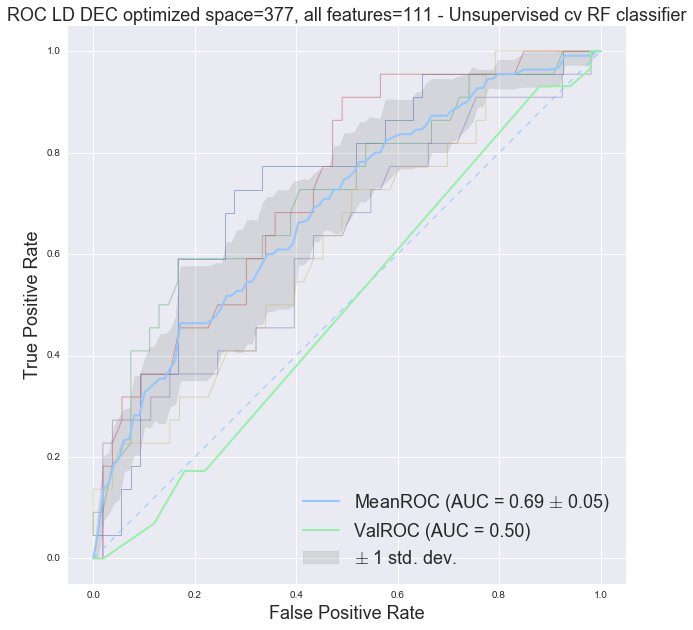

Loading autoencoder of znum = 104, mu = 8 , post training DEC results


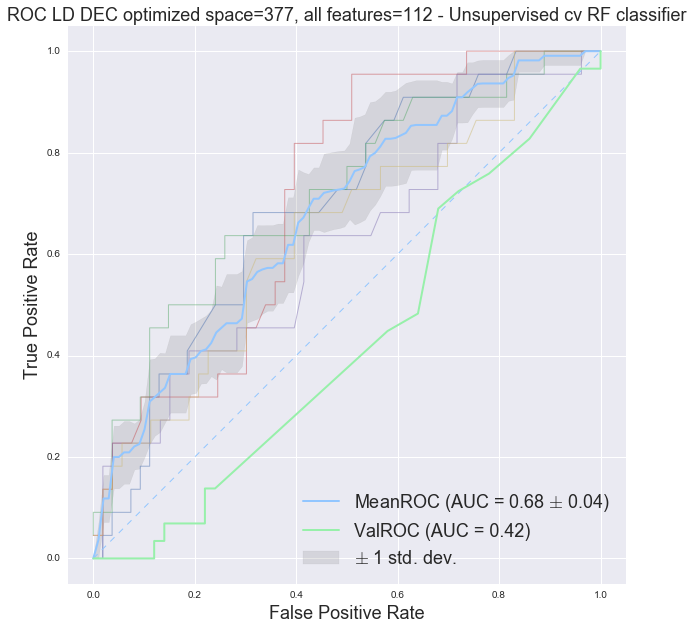

Loading autoencoder of znum = 104, mu = 9 , post training DEC results


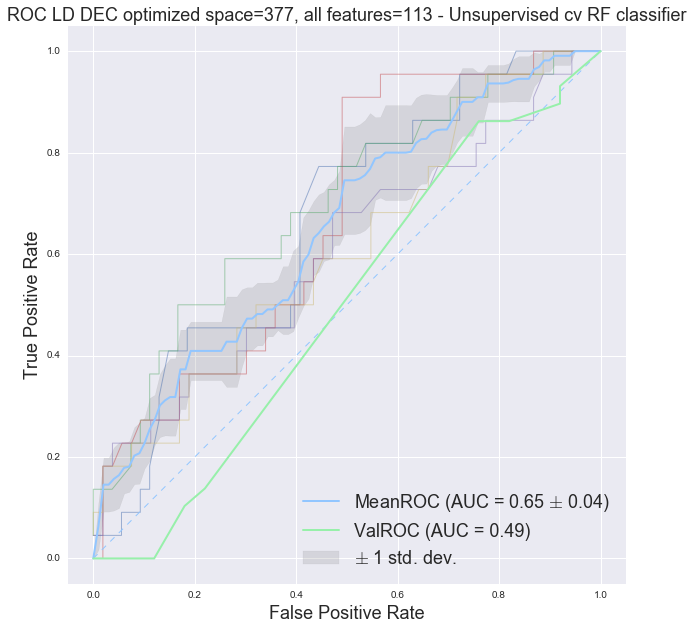

Loading autoencoder of znum = 104, mu = 10 , post training DEC results


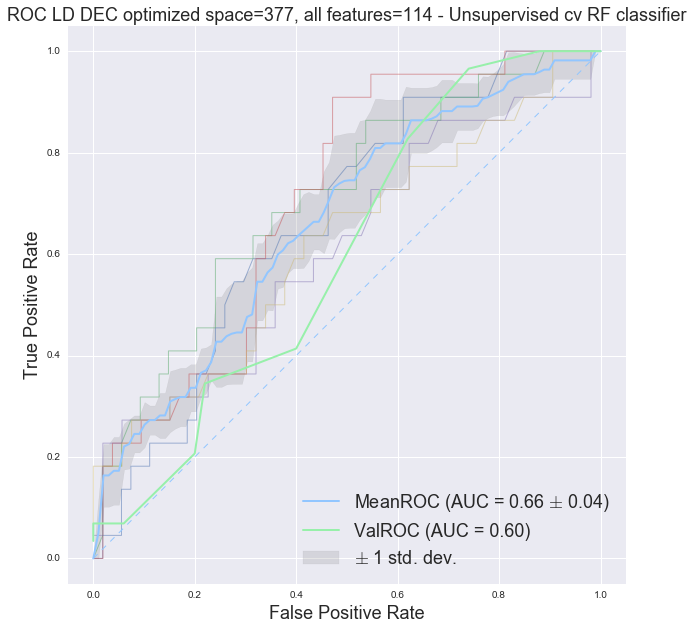

In [6]:
# set config variables
from decModel_wimgF_dualopt_descStats import *
labeltype = 'decModel_wimgF_AUCopt_descStats' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_AUCopt_descStats'

# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2,5]] # other: 10,15,25
varying_mu = [int(np.round(var_mu)) for var_mu in np.linspace(3,10,8)]

for znum in latent_size:
    for num_centers in varying_mu: 
        # unbiased validation with held-out set
        sep = int(combX_allNME.shape[0]*0.10)
        X_val = combX_allNME[:sep]
        y_val = roi_labels[:sep]
        
        X_train = combX_allNME
        y_train = roi_labels
        
        # Run classifier with cross-validation and plot ROC curves
        cv = StratifiedKFold(n_splits=5)
        RFmodel = RandomForestClassifier(n_jobs=2, n_estimators=500, max_depth=20, random_state=0, verbose=0)

        # Z-space DEC patams optimized with RF classfier by cross-validation
        print('Loading autoencoder of znum = {}, mu = {} , post training DEC results'.format(znum,num_centers))
        dec_model = DECModel(mx.cpu(), X_train, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)

        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)

        # format data
        datalabels = np.asarray(y_train)
        dataZspace = np.concatenate((dec_model['zbestacci'], dec_model['pbestacci']), axis=1) #zbestacci #dec_model['zbestacci']   
        Z = dataZspace[datalabels!='K',:]
        y = np.asarray(datalabels[datalabels!='K']=='M').astype(int)
        
        # Evaluate a score by cross-validation
        figROCs = plt.figure(figsize=(10,10))                  
        tprs = []; aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        cvi = 0
        for train, test in cv.split(Z, y):
            probas = RFmodel.fit(Z[train], y[train]).predict_proba(Z[test])
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas[:, 1])
            # to create an ROC with 100 pts
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            # plot
            axaroc = figROCs.add_subplot(1,1,1)
            axaroc.plot(fpr, tpr, lw=1, alpha=0.5) # with label add: label='cv %d, AUC %0.2f' % (cvi, roc_auc)
            cvi += 1

        axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=1)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        axaroc.plot(mean_fpr, mean_tpr, color='b',
                 label=r'MeanROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=1)     
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.') 
        
        ################
        # plot AUC on validation set
        ################
        dec_args_keys = ['encoder_0_bias','encoder_1_bias','encoder_2_bias','encoder_3_bias',
                         'encoder_0_weight','encoder_1_weight','encoder_2_weight','encoder_3_weight']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mubestacci'].asnumpy()

        # Evaluate on embedded space
        #####################        
        ## embedded point zi X_val
        all_X_val = mx.io.NDArrayIter({'data': X_val}, 
                                     batch_size=X_val.shape[0], 
                                     shuffle=False, last_batch_handle='pad') 
  
        aDEC = DECModel(mx.cpu(), X_val, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        z_val = model.extract_feature(aDEC.feature, mxdec_args, None, all_X_val, X_val.shape[0], aDEC.xpu).values()[0]      
        p_val = np.zeros((z_val.shape[0], dec_model['num_centers']))
        aDEC.dec_op.forward([z_val, dec_args['dec_mubestacci']], [p_val])
    
        # format to predict
        y_val_bin = (np.asarray(y_val)=='M').astype(int)
        Z_val = np.concatenate((z_val, p_val), axis=1)         
        probas_val = RFmodel.fit(Z, y).predict_proba(Z_val)

        # Compute ROC curve and area the curve
        fpr_val, tpr_val, thresholds_val = roc_curve(y_val_bin, probas_val[:, 1])
        auc_val = auc(fpr_val, tpr_val)
        axaroc.plot(fpr_val, tpr_val, color='g',
                    label=r'ValROC (AUC = %0.2f)' % (auc_val),
                     lw=2, alpha=1)     

        axaroc.set_xlim([-0.05, 1.05])
        axaroc.set_ylim([-0.05, 1.05])
        axaroc.set_xlabel('False Positive Rate',fontsize=18)
        axaroc.set_ylabel('True Positive Rate',fontsize=18)
        axaroc.set_title('ROC LD DEC optimized space={}, all features={} - Unsupervised cv RF classifier'.format(Z.shape[0],Z.shape[1]),fontsize=18)
        axaroc.legend(loc="lower right",fontsize=18)
        plt.show()
       
        

## 3) Unsupervised learning in optimal LD space: DEC + fully connected MLP classifier

## Experiment: decModel_wimgF_AUCopt_descStats
### NOTES:

In [18]:
print('SAE trained on ALL pooled variables, HD n= 523')
print('zero normed LD Z-space znum = reduced [x2,x5,x10,x15,x25]: \nSAE_zsize{znum}_wimgfeatures_descStats_zeromean.arg \n')

print('DEC optimization = Solver(sgd, learning_rate=0.1,lr_scheduler=mx.misc.FactorScheduler(200,0.1)) \n')
DEC_batch_size = 125     
update_interval = 20
epochs_update = float(DEC_batch_size*update_interval)/X_train.shape[0]
print('DEC batch_size = {}, update_interval = {} \nTraining DEC, updating parameters every ~ {} Epochs \n '.format(DEC_batch_size,update_interval,epochs_update))
print('DEC overall_metric = - np.log(mean_auc)\n ')

MLP_batch_size = 50
print('MLP batch_size = {}, Training DEC + MLP fully connected classifier \n '.format(MLP_batch_size))


SAE trained on ALL pooled variables, HD n= 523
zero normed LD Z-space znum = reduced [x2,x5,x10,x15,x25]: 
SAE_zsize{znum}_wimgfeatures_descStats_zeromean.arg 

DEC optimization = Solver(sgd, learning_rate=0.01,lr_scheduler=mx.misc.FactorScheduler(200,0.1)) 

DEC batch_size = 125, update_interval = 20 
Training DEC, updating parameters every ~ 3.15656565657 Epochs 
 
DEC overall_metric = - np.log(mean_auc)
 
MLP batch_size = 50, Training DEC + MLP fully connected classifier 
 


Loading autoencoder of znum = 261, mu = 3 , post training DEC results
DEC train init AUC = 0.67093731432
DEC train max AUC = 0.726596850862
DEC validation AUC at max train = 0.755862068966
DEC train AUC at max val = 0.678669043375
DEC validation AUC at max val = 0.792413793103
DEC resulting NMI=0.0501896189929
... num_centers=3 DEC normalizedMI = 0.129742530738

Loading autoencoder of znum = 261, mu = 4 , post training DEC results
DEC train init AUC = 0.668218954248
DEC train max AUC = 0.7292409388
DEC validation AUC at max train = 0.728965517241
DEC train AUC at max val = 0.696434937611
DEC validation AUC at max val = 0.77724137931
DEC resulting NMI=0.0818483983459
... num_centers=4 DEC normalizedMI = 0.145590772905

Loading autoencoder of znum = 261, mu = 5 , post training DEC results
DEC train init AUC = 0.665938799762
DEC train max AUC = 0.723655674391
DEC validation AUC at max train = 0.736551724138
DEC train AUC at max val = 0.691458704694
DEC validation AUC at max val = 0.776551

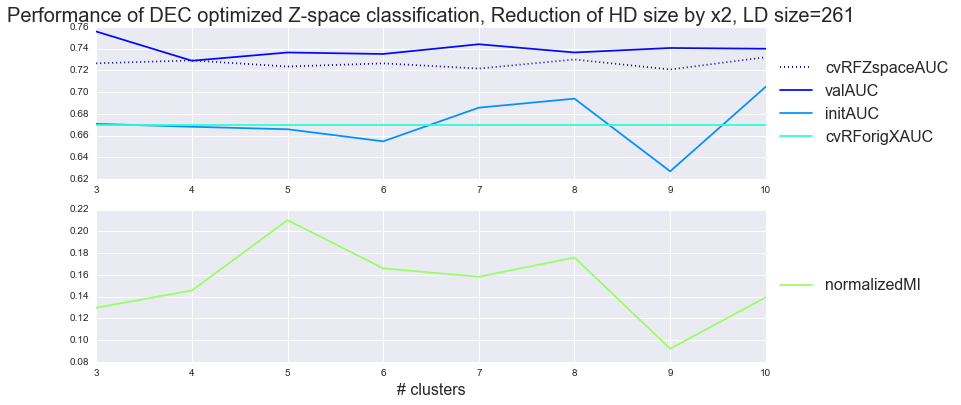

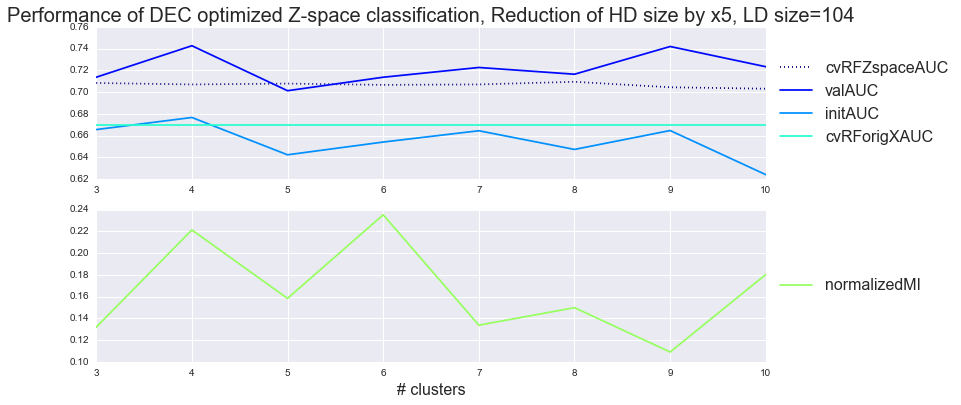

In [25]:
# set config variables
from decModel_wimgF_dualopt_descStats import *
labeltype = 'decModel_wimgF_AUCopt_descStats' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_AUCopt_descStats'

# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2,5]] # other: 10,15,25
varying_mu = [int(np.round(var_mu)) for var_mu in np.linspace(3,10,8)]

######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
for znum in latent_size:
    cvRForigXAUC = []
    initAUC = []
    valAUC = []
    cvRFZspaceAUC = []           
    normalizedMI = []
    for num_centers in varying_mu: 
        # batch normalization
        X_train = combX_allNME
        y_dec_train = y_dec
        y_train = roi_labels
        batch_size = X_train.shape[0]

        print('Loading autoencoder of znum = {}, mu = {} , post training DEC results'.format(znum,num_centers))
        dec_model = DECModel(mx.cpu(), X_train, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)

        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)

        print('DEC train init AUC = {}'.format(outdict['meanAuc_cv'][0]))
        max_meanAuc_cv = max(outdict['meanAuc_cv'])
        indmax_meanAuc_cv = outdict['meanAuc_cv'].index(max_meanAuc_cv)
        print('DEC train max AUC = {}'.format(max_meanAuc_cv))
        print('DEC validation AUC at max train = {}'.format(outdict['auc_val'][indmax_meanAuc_cv]))
        
        max_auc_val = max(outdict['auc_val'])
        indmax_auc_val = outdict['auc_val'].index(max_auc_val)
        print('DEC train AUC at max val = {}'.format(outdict['meanAuc_cv'][indmax_auc_val]))
        print('DEC validation AUC at max val = {}'.format(max_auc_val))
        print('DEC resulting NMI={}'.format(outdict['NMI']))
        
        # to plot metrics for all varying_mu
        cvRForigXAUC.append(0.67)
        initAUC.append(outdict['meanAuc_cv'][0])
        cvRFZspaceAUC.append(outdict['meanAuc_cv'][indmax_meanAuc_cv])
        valAUC.append(outdict['auc_val'][indmax_meanAuc_cv])
        # or to calculate NMI
        # save output results
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mubestacci']
        
        # Calculate normalized MI: find the relative frequency of points in Wk and Cj
        #####################
        N = X_train.shape[0]
        num_classes = len(np.unique(roi_labels)) # present but not needed during AE training
        roi_classes = np.unique(roi_labels)
        y_train_roi_labels = np.asarray(y_train)
        
        # extact embedding space
        all_iter = mx.io.NDArrayIter({'data': X_train}, batch_size=X_train.shape[0], shuffle=False,
                                                  last_batch_handle='pad')   
        ## embedded point zi 
        aDEC = DECModel(mx.cpu(), X_train, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        
        # gather best-Zspace or dec_model['zbestacci']
        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X_train.shape[0], aDEC.xpu).values()[0]      
        # compute model-based best-pbestacci or dec_model['pbestacci']
        # pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        # aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        pbestacci = dec_model['pbestacci']
        
        # find max soft assignments dec_args
        W = pbestacci.argmax(axis=1)
        clusters = range(dec_model['num_centers'])
        num_clusters = len(np.unique(W))
        
        MLE_kj = np.zeros((num_clusters,num_classes))
        absWk = np.zeros((num_clusters))
        absCj = np.zeros((num_classes))
        for k in range(num_clusters):
            # find poinst in cluster k
            absWk[k] = np.sum(W==k)
            for j in range(num_classes):
                # find points of class j
                absCj[j] = np.sum(y_train_roi_labels==roi_classes[j])
                # find intersection 
                ptsk = W==k
                MLE_kj[k,j] = np.sum(ptsk[y_train_roi_labels==roi_classes[j]])
        # if not assignment incluster
        absWk[absWk==0]=0.00001
        # compute NMI
        numIwc = np.zeros((num_clusters,num_classes))
        for k in range(num_clusters):
            for j in range(num_classes):
                if(MLE_kj[k,j]!=0):
                    numIwc[k,j] = MLE_kj[k,j]/N * np.log( N*MLE_kj[k,j]/(absWk[k]*absCj[j]) )
                
        Iwk = np.sum(np.sum(numIwc, axis=1), axis=0)       
        Hc = -np.sum(absCj/N*np.log(absCj/N))
        Hw = np.sum(absWk/N*np.log(absWk/N))
        NMI = Iwk/(np.abs(Hc+Hw))
        print("... num_centers={} DEC normalizedMI = {}".format(num_centers,NMI))
        normalizedMI.append(NMI)
        print("========================\n")
    
    # plot latent space Accuracies vs. original
    colors = plt.cm.jet(np.linspace(0, 1, 16))
    fig2 = plt.figure(figsize=(12,6))
    #ax2 = plt.axes()
    sns.set_context("notebook")
    ax1 = fig2.add_subplot(2,1,1)
    ax1.plot(varying_mu, cvRFZspaceAUC, color=colors[0], ls=':', label='cvRFZspaceAUC')
    ax1.plot(varying_mu, valAUC, color=colors[2], label='valAUC')
    ax1.plot(varying_mu, initAUC, color=colors[4], label='initAUC')
    ax1.plot(varying_mu, cvRForigXAUC, color=colors[6], label='cvRForigXAUC')
    h1, l1 = ax1.get_legend_handles_labels()
    ax1.legend(h1, l1, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
    
    ax2 = fig2.add_subplot(2,1,2)
    ax2.plot(varying_mu, normalizedMI, color=colors[8], label='normalizedMI')
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.legend(h2, l2, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
    ax2.set_xlabel('# clusters',fontsize=16)
    ax1.set_title('Performance of DEC optimized Z-space classification, Reduction of HD size by x{}, LD size={}'.format(input_size/znum, znum),fontsize=20)
        